In [5]:
import re
stop_word = ['?', '.']
def clearing_word(word):
    word = re.sub('\x8e', 'é', word)
    word = re.sub('\x88', 'à', word)
    word = re.sub('\x9d', 'ù', word)
    word = re.sub('\x8f', 'è', word)
    word = re.sub('\x9e', 'û', word)
    word = re.sub('\x90', 'ê', word)
    word = re.sub('\x99', 'ô', word)
    word = re.sub('\x94', 'î', word)
   # word = re.sub('\x8f', 'è', word)
    word = re.sub('\x8d', 'ç', word)
    word = re.sub('õ', '', word)
    word = re.sub('Ê', '', word)
    word = re.sub('[?,.,!, \,,  %]', '', word)
    if word == 'û' or word == 'v' or word == 'é':
        word = ''
    if word =="2017êles":
        word = "2017"
    if "ênox" in word:
        word ="nox"
    return word

def clearing(pharse):
    """
    Arg: Data is a list of questions or answers
    Return: clean questions et answers 
    """
    #clean_data = []
    pharses =[]
    for word in pharse.strip().lower().split(' '):
       # line= data[i].lower().split(' ')        
        #for word in line:
        word = clearing_word(word)
        if word not in stop_word and len(word) !=0:       
            pharses.append(word)        
    return ' '.join(pharses)



def get_all_convos():
    convos = []
    file2 = 'chatbot_tout_corpus_13juin.txt'
    liste_file = [ file2]
    for file in liste_file:
        with open(file) as f:
            i=0
            for line in f:
                if i%2==0:
                    question = clearing(line)
                    if '++++' in question:
                         question = question[9:]
                else:
                    answer = clearing(line)
                    if '++++' in answer:
                        answer = answer[9:]
                    convos.append([question, answer])
                i+=1
        f.close()
    return convos

In [1]:
"""
Cet technique marche beaucoup mieux que dans tensorflow, avec en très peu de temps. 
Ce modèle fonctionne mieux que l'autre dans tensorflow parce qu'une raison évidente: 
il utilise méthode teacher forcing Un autre problème avec ce méthode, 
c'est dropout qui donne une technique plus ou moins bon. Il donne la 
réponse plus tôt aléatoire pour une question. En cas général, 
ce la peut être intéressant, mais dans notre cas, il est très important 
qu'il capture le mot clés 
(donc, surtout on risque de supprimer le mot clés, qui rendra une mauvais réponse)
modèle est bien entrainé, donc, il ne sert à rien d'entrainer encore.
hidden_size =45 tres mauvais; =70 bien; =100 tres bien; =120 très bien; =150 overfit.
hidden_size 50 20%
hidden_size 70 33%
hidden_size 120 28%
"""
#from IPython.display import display, Markdown
#display(Markdown("### Pour lancer un chat, il suffit de taper en même temps CTRL et ENTER"))
#display(Markdown("### Pour arrêter le mode chat, il suffit de taper ENTER dans votre conversation"))
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import data
import config
import time
from dateparser.search import search_dates
import pandas as pd


use_cuda = torch.cuda.is_available()

hidden_size = 20
SOS_token  = config.SOS_token
EOS_token  = config.EOS_token
MAX_LENGTH = config.MAX_LENGTH
stopwords  = config.STOPWORDS
learning_rate = config.LEARNING_RATE
teacher_forcing_ratio = 0.2
dropout = config.DROPOUT

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def normalizeString(s):
    """
    Whith a tring s, we make it in lower case, delete \n if exists at 
    the end of string, and delete specical case ? . and !
    """
    s = s.lower().strip()
    s = re.sub(r"([,.!?\n])", r"", s)# sumprimer tous les caractères .! et ?
    #s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

def readLangs():
    print("Reading lines...")
    pairs_trains, pairs_tests = [], []   
    encode_train = open(os.path.join(config.PROCESSED_PATH, "question_train.txt"), 'r')
    decode_train = open(os.path.join(config.PROCESSED_PATH, "answer_train.txt"), 'r')
    encode, decode = encode_train.readline(), decode_train.readline()
    while encode and decode:
        encode, decode = normalizeString(encode), normalizeString(decode)
        decode = 'SOS '+ decode + ' EOS'
        pairs_trains.append([encode, decode])
        encode, decode = encode_train.readline(), decode_train.readline()
    encode_train.close()
    decode_train.close()
    encode_test = open(os.path.join(config.PROCESSED_PATH, "question_test.txt"), 'r')
    decode_test = open(os.path.join(config.PROCESSED_PATH, "answer_test.txt"), 'r')
    encode, decode = encode_test.readline(), decode_test.readline()
    while encode and decode:
        encode, decode = normalizeString(encode), normalizeString(decode)
        decode = 'SOS '+ decode + ' EOS'
        pairs_tests.append([encode, decode])
        encode, decode = encode_test.readline(), decode_test.readline()
    encode_test.close()
    decode_test.close()
    return pairs_trains, pairs_tests


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData( PAIRS):
    input_lang = Lang('question')
    output_lang = Lang( 'answer')
    pairs_trains, pairs_tests = [], []
    #PAIRS.extend(pairs1)
    index_train = random.sample(range(len(PAIRS)), int(len(PAIRS)*0.80))
    for i in range(len(PAIRS)):
        if i in index_train:
            pairs_trains.append(PAIRS[i])
        else:
            pairs_tests.append(PAIRS[i])
    print("Read %s sentence pairs of training set" % len(pairs_trains))
    print("Read %s sentence pairs of test set" % len(pairs_tests))
    pairs_trains = filterPairs(pairs_trains)
    pairs_tests = filterPairs(pairs_tests)
    for i  in range(len(pairs_trains)) :
        pair = pairs_trains[i]
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    for i  in range(len(pairs_tests)) :
        pair = pairs_tests[i]
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs_trains, pairs_tests

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
def closetWord(word, lang):
    """
    find and return the closest word in lang
    """
    Dict = lang.word2index
    corpus = lang.index2word
    if word in Dict:
        return word
    else:
        distance = levenshtein(word, corpus[0])
        close_word = corpus[0]
        for ix in corpus:
            if levenshtein(word, corpus[ix]) <distance:
                close_word = corpus[ix]
                distance = levenshtein(word, corpus[ix])
        if distance <=1:
            return close_word
        else:
            return word
        
def normalizeSentenceInChat(sentence):
    sentence = sentence.strip().lower().split()
    s = [closetWord(word, input_lang) for word in sentence]
    return ' '.join(s)
        
        
            

def indexesFromSentence(lang, sentence):
    #sentence = normalizeSentence
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index ]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)


def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
def get_skip_step(n_iters):
    return int(n_iters/10)

def trainIters(n_iters, plot_every=100, learning_rate=learning_rate):
    training_pairs = get_all_convos()
    encoder, decoder = restore_model()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    skip_step = get_skip_step(n_iters)
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs_trains))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % skip_step == 0:
            print_loss_avg = print_loss_total / skip_step
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    save_model(encoder, decoder)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    #sentence = normalizeSentenceInChat(sentence)
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        ni = int(ni)
        if ni == EOS_token:
            #decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words


def evaluate_randomly(n_iters=200, test=True):
    encoder, decoder = restore_model()
    if not test:
        print('TEST error of word to word on TRAIN')
        list_print_random = random.sample(range(n_iters),20 )
        total_loss = 0
        for i in range(n_iters):
            pair = random.choice(pairs_trains)
            output_words = evaluate(encoder, decoder, pair[0])
            if 'EOS' in output_words:
                l = output_words.index('EOS')+1
            else:
                l = len(output_words)+1
            reponse = ' '.join(output_words[:l])
            loss = _evaluate_by_right_word(pair[1], reponse)
            total_loss +=loss
            if i in list_print_random:
                #answer = answers_with_data(pair[0], reponse)
                print('Question: ', pair[0])
                print('Réponse: ', pair[1])
                print('Bot: {}   ACCURACY {:.1f}'.format(reponse, 1-loss))
                #if answer != reponse:
                 #   print('Réponse avec data:', answer)
                
                print('-'*50)
        print('Accuracy of good answer word to word: ', 1-total_loss/n_iters)
    else:
        n_iters = len(pairs_tests)
        total_loss = 0
        random_print_index = random.sample(range(n_iters), 20)
        for i in range(n_iters):
            pair = pairs_tests[i]
            output_words= evaluate(encoder, decoder, pair[0])
            if 'EOS' in output_words:
                l = output_words.index('EOS')+1
            else:
                l = len(output_words)+1
            reponse = ' '.join(output_words[:l])
            loss = _evaluate_by_right_word(pair[1], reponse)
            if i in random_print_index:
                print('Question: ', pair[0])
                print('Réponse: ', pair[1])
                print('Bot: {}. ACCURACY {:.1f}'.format(reponse, 1-loss))
                print('-'*50)
            total_loss +=loss
        print('Test on {}'.format(n_iters))
        print('Accuracy by percent of true words {}'.format(1-total_loss/n_iters))
 

KEYWORD_TO_FUNCTION_DICT = {'#id#':'ID Véhicule','#km#':'Distance', '#check_batterie#':'Tension Batterie',\
                            '#vitesse#':'Vitesse Moyenne'}

def answers_with_data(question, answer):
    data = analyse_reponse(question, answer)
    if data is None:
        return answer
    else:
        index = 0
        for word in answer.split():
            if "#" in word:
                try:
                    good_answer = re.sub(word, str(data[index]), answer)
                except IndexError:
                    break
                index +=1
        return good_answer
    
                
def analyse_reponse(question, answer):
    """
    arg: question is the question of user, reponse is given by chatbot

    """
    if '#' not in answer:
        return None
    else:
        parameter = []
        for key in KEYWORD_TO_FUNCTION_DICT:
            if key in answer.split():
                parameter.append(key)
        times = find_right_time(question)
        variables = _get_variable(answer)
        data = []
        if len(variables)==0:
            return None
        else:
            ids = find_ids(question)
            for variable in variables:
                data.append(_get_data_from_table(ids, variable, times))
            return data
            
                
def find_right_time(question):
    """
    cette fonction retourne période de temps dans la question"""
    dictionnary = {'cette':'1', 'ce':'1', "dernier": '1',"dernière": '1' }
    for word in dictionnary:
        question = re.sub(word, dictionnary[word], question)
    end_time = time.time()
    try:
         t = search_dates(question)
    except ZeroDivisionError:
        return None, None
    if t == None:
        return None, None
    
    else:
        if len(t)>=2:
        
            t0 = t[0][-1]
            start_time = time.mktime(t0.timetuple())
                
            t1 = t[-1][-1]
            end_time = time.mktime(t1.timetuple())
        if len(t)==1:
            t = t[0][1]
            start_time = time.mktime(t.timetuple())
    #start_time, end_time = find_good_time_in_table(start_time, end_time)
    return start_time, end_time
    

def _get_variable(reponse):
    list_variable =[]
    for word in reponse.split():
        if "#" in word:
            list_variable.append(word)
    #if variable in KEYWORD_TO_FUNCTION_DICT:
    return [KEYWORD_TO_FUNCTION_DICT[variable] for variable in list_variable
               if variable in KEYWORD_TO_FUNCTION_DICT]

    
def _get_data_from_table(ids, variable, time):
    """
    temps est un couple de début et fin
    """
    df = pd.read_csv('fleet_donnees.csv', sep = ';')
    #time1 = string_to_datetime(time[0])
    #time2 = string_to_datetime(time[1])
    if variable is None:
        return "#TO_CONSTRUCT#"
    if variable =='Tension Batterie':
        return min(df['Tension Batterie'])
    time1 = time[0]
    time2 = time[1]
    if time1 is None:
        time1 = string_to_datetime(df.iloc[0]['Debut période'])
    if time2 is None:
        time2 = string_to_datetime(df.iloc[len(df)-1]['Fin Période'])
    if ids is not None:
        try:
            df = df.loc[(df['ID Véhicule'] ==  int(ids))] 
        except ValueError:
            pass
    List = []
    for i in range(len(df)):
        if string_to_datetime(df.iloc[i]['Debut période']) >=time1 and \
           string_to_datetime(df.iloc[i]['Fin Période'])<=time2:
                List.append(i)

    list_data_to_return = df.iloc[List][variable]
    if len(list_data_to_return)>1:
        t = sum(list_string_to_float(list_data_to_return))/len(list_data_to_return)
    else:
        t= list_data_to_return
    
   # try:
       # t=sum(list_data_to_return.values[0])/len(list_to_return.values[0])
   # except AttributeError or IndexError:
   # t = sum(list_data_to_return)/len(list_data_to_return)
    return t
        
          
def find_ids(question):
    if 'tous' in question or 'toutes' in question or 'tout'in question or 'toute' in question:
        return None
    return None
    #else:
     #   print('La liste de ID des voitures:')
      #  imprimer_id()
       # return str(input('indiquez l\'identifiant de ce véhicule:'))
    

def string_to_datetime(string):
    t = search_dates(string)
    t = t[0][1]
    t = time.mktime(t.timetuple())
    return t

def list_string_to_float(List_string):
    List = []
    for string in List_string:
        if type(string)==str:
            string = re.sub(',', '.', string)
        else:
            pass
        string2float  = float(string)
        List.append(string2float)
    return List
    
def find_good_time_in_table(begin_time, end_time):
    """
    begin_time and end_time is in float type
    return right begin_time and end_time in table"""   
    import pandas as pd
    df = pd.read_csv('fleet_donnees.csv', sep = ';')
    start_time_colone = df['Debut période']
    end_time_colone = df['Fin Période']
    start_time_table = []
    for i in start_time_colone:
        time,_=find_right_time(i)
        start_time_table.append(time)
    end_time_table = []
    for i in fin_time_colone:
        time, _ = find_right_time(i)
        end_time_table.append(time)
    start = start_time_table[-1]
    for i in start_time_table:
        if begin_time <= i:
            start = i
            break
    end = end_time_table[-1]
    for i in end_time_table:
        if end <=i:
            end = i
            break
    #start = start_time_table[start_time_table==start].index[0]
    #end = fin_time_table[fin_time_table==end].index[0]
    start = start_time_table.index(start)
    end =  end_time_table.index(end)
    start = start_time_colone[start]
    end = _time_colone[end]
    return start, end    
    
    
def _evaluate_by_right_word(reponse, bonne_reponse):
    reponse = reponse.split()
    bonne_reponse = bonne_reponse.split()
    min_length = min(len(reponse), len(bonne_reponse))
    max_length = max(len(reponse), len(bonne_reponse))
    error = max_length-min_length
    for i in range(min_length):
        if reponse[i] != bonne_reponse[i]:
            error +=1
    return error/max_length      
        
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
def save_model(encoder, decoder):        
    make_dir(config.CHECK_POINT_PATH)
    path1= os.path.join(config.CHECK_POINT_PATH, 'encoder_simulation_3.ck')
    path2 = os.path.join(config.CHECK_POINT_PATH, 'decoder_simulation_3.ck')
    try: 
        os.remove(path1)  
        os.remove(path2)
    except FileNotFoundError:
        pass
    torch.save(encoder,path1)
    torch.save(decoder, path2)
    
memo = {}
def levenshtein(s, t):
    """
    Pour calculer la distance  Levenshtein entre 2 string s et t
    """
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    cost = 0 if s[-1] == t[-1] else 1
       
    i1 = (s[:-1], t)
    if not i1 in memo:
        memo[i1] = levenshtein(*i1)
    i2 = (s, t[:-1])
    if not i2 in memo:
        memo[i2] = levenshtein(*i2)
    i3 = (s[:-1], t[:-1])
    if not i3 in memo:
        memo[i3] = levenshtein(*i3)
    res = min([memo[i1]+1, memo[i2]+1, memo[i3]+cost])
    
    return res
    
def restore_model():
    #hidden_size = hidden_size
    path1 = os.path.join(config.CHECK_POINT_PATH, 'encoder_simulation_3.ck')
    path2 = os.path.join(config.CHECK_POINT_PATH, 'decoder_simulation_3.ck')
    if os.path.exists(path1)and os.path.exists(path2):
        print('Reading the parameters from {} and {}...'.format(path1, path2))
        encoder = torch.load(path1)
        decoder = torch.load(path2)
    else:
        print('Initializing fresh parameters...')
        encoder = EncoderRNN(input_lang.n_words, hidden_size)
        decoder = DecoderRNN(hidden_size, output_lang.n_words,1)

    if use_cuda:
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    return encoder, decoder 

def imprimer_id():
    df = pd.read_csv('fleet_donnees.csv', sep = ';')   
    df = df['ID Véhicule']
    List_voiture = []
    for i in df:
        if i not in List_voiture:
            List_voiture.append(i)
    for i in List_voiture:
        print(i, end='  ')

def construct_dict(lang):
    in_file = open(os.path.join(config.PROCESSED_PATH, 'dictionnary.txt'), 'r')
    lines = []
    dicts = lang.word2index.copy()
    for line in in_file:
        line = line.strip().split('|')
        for word in dicts:
            if str(word) in line and len(word)>0:
                line.insert(0,str(word))
                lines.append(line)
                del dicts[str(word)]
                break
    return lines

def find_close_line(lines, lang, line):
    LINE = []
    for word in line.strip().split():
        if word in lang.word2index:
            LINE.append(word)
        else:
            for pharse in lines:
                if word in pharse:
                    LINE.append(pharse[0])
                    break
    return ' '.join(LINE)

def chat():
    encoder, decoder = restore_model()
    make_dir(config.CHECK_POINT_PATH)
    lines = construct_dict(input_lang)
    output_file = open(os.path.join(config.CHECK_POINT_PATH, 'convos70.txt'), 'a+')
    print('Bonjour, c\'est le Bot d\'AVICEN, Je peux vous aider? \n')
    while True:
            line = str(input('Vous: '))
            if len(line) > 0 and line[-1] == '\n':
                line = line[:-1]
            if line == '':
                break
            line = normalizeString(line)
            transform_line  = normalizeSentenceInChat(line)
            transform_line = find_close_line(lines, input_lang, transform_line)
            print('LIGNE TRANFORMÉ: ', line)
            output_file.write('VOUS ++++ ' + line + '\n')
            reponse = evaluate(encoder, decoder, transform_line)
            if 'SOS' in reponse:
                 reponse = reponse[1:] 
            if 'EOS' in reponse:
                reponse = reponse[:-1] 
            reponse = " ".join(reponse)
            output_file.write('BOT ++++ ' + reponse + '\n')
            print('Without Data: ', reponse)
            reponse = answers_with_data(line, reponse)
            print('Bot AVICEN: ', reponse)
            print('-'*50)
    output_file.close() 

def test(pairs_test):
    """
    Use test for know how our model is good
    """
    encoder, decoder = restore_model()
    total_loss = 0
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    for pair in pairs_test:
        variable = variablesFromPair(pair)
        loss = train( variable[0], variable[1], encoder, decoder, encoder_optimizer, decoder_optimizer,\
                     criterion= criterion)
        total_loss +=loss
    Length_inputs = len(pairs_test) if len(pairs_test) !=0 else 1
    return total_loss/Length_inputs



###############################################################################-----------------------
import re
stop_word = ['?', '.']
def clearing_word(word):
    word = re.sub('\x8e', 'é', word)
    word = re.sub('\x88', 'à', word)
    word = re.sub('\x9d', 'ù', word)
    word = re.sub('\x8f', 'è', word)
    word = re.sub('\x9e', 'û', word)
    word = re.sub('\x90', 'ê', word)
    word = re.sub('\x99', 'ô', word)
    word = re.sub('\x94', 'î', word)
   # word = re.sub('\x8f', 'è', word)
    word = re.sub('\x8d', 'ç', word)
    word = re.sub('õ', '', word)
    word = re.sub('Ê', '', word)
    word = re.sub('[?,.,!, \,,  %]', '', word)
    if word == 'û' or word == 'v' or word == 'é':
        word = ''
    if word =="2017êles":
        word = "2017"
    if "ênox" in word:
        word ="nox"
    return word

def clearing(pharse):
    """
    Arg: Data is a list of questions or answers
    Return: clean questions et answers 
    """
    #clean_data = []
    pharses =[]
    for word in pharse.strip().lower().split(' '):
       # line= data[i].lower().split(' ')        
        #for word in line:
        word = clearing_word(word)
        if word not in stop_word and len(word) !=0:       
            pharses.append(word)        
    return ' '.join(pharses)



def get_all_convos():
    convos = []
    file2 = 'chatbot_tout_corpus_13juin.txt'
    liste_file = [ file2]
    for file in liste_file:
        with open(file) as f:
            i=0
            for line in f:
                if i%2==0:
                    question = clearing(line)
                    if '++++' in question:
                         question = question[9:]
                else:
                    answer = clearing(line)
                    if '++++' in answer:
                        answer = answer[9:]
                    convos.append([question, answer])
                i+=1
        f.close()
    return convos

DIRECT_VARIABLE = ['vitesse', 'batterie', 'position', 'km']
TIME = []
GEOGRAPHY = ['Lyon', 'hors lyon', 'paris', 'l\'étranger','france' , 'hors la france']
BORDE = {'MAX': ['plus grand', 'plus grande', 'plus grands', 
         'plus grandes',  'moin faible', 'moins faibles',
         'plus vite', 'max', 'maximum', 'maximal', 'maximaux', 'maximale',
        'plus haut', 'plus haute', 'plus hautes', 'plus hauts',  
        'plus élevé', 'plus élevée', 'plus élevés', 'plus élevées'], 
         'MIN':['moins grand', 'moins grande', 'moins grands','moins grandes',
        'plus petit', 'plus petite', 'plus petits', 'plus petites','plus faible', 'plus faibles', 
         'min', 'minimal', 'minimale', 'minimales', 'minimaux','moins vite', 
         'moins élevé', 'moins élevée', 'moins élevés', 'moins élevées'],
        'MOYENNE': ['moyenne', 'moyen', 'moyennement']
        }
COMPLEX_ANALYSIS = ['problème', 'problèmes', 'erreurs', 'erreur', 'danger']
PAIRS = []
question_for_simulation = ['quels véhicules ont', 'quel véhicule', 'quelle voiture', 'quelles voitures']
reponse_for_simulation = 'véhicule'
for borde in BORDE:
    for word in BORDE[borde]:
        for direct_variable in DIRECT_VARIABLE:
            for question_f_s in question_for_simulation:
                if direct_variable !='position':
                      question= question_f_s+' '+direct_variable + ' '+ word
                      key0 = '#id#'
                      key1 = '#'+direct_variable+'#'
                      key2 = '#'+borde +'#'
                      reponse = reponse_for_simulation +' '+key0+ ' '+ key1+ ' '+ key2
                      PAIRS.append([question,reponse])

question_for_simulation = ['', 'quel véhicule a', 'quelle voiture a', 'quelles voitures ont', 'il y a']
reponse_for_simulation = 'véhicule' 
for direct_variable in DIRECT_VARIABLE:
    for complex_analysis in COMPLEX_ANALYSIS:
            for question_f_s in question_for_simulation:
                #if direct_variable !='position':
                      question= question_f_s+' '+complex_analysis + ' '+ direct_variable
                      key0 = '#id#'
                      key1 = '#'+direct_variable+'#'
                      key2 = '#'+ complex_analysis +'#'
                      reponse = reponse_for_simulation +' '+key0+ ' '+ key2 +' '+ key1
                      PAIRS.append([question,reponse])

if __name__=='__main__':
    try:
        input_lang
    except NameError :
        #pairs1 = get_all_convos()
        input_lang, output_lang, pairs_trains, pairs_tests = prepareData( PAIRS)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Read 492 sentence pairs of training set
Read 124 sentence pairs of test set
Counted words:
question 59
answer 16


Reading the parameters from check_point/encoder_simulation_3.ck and check_point/decoder_simulation_3.ck...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:299: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0m 16s (- 2m 31s) (5000 10%) 0.1897
0m 32s (- 2m 11s) (10000 20%) 0.1488
0m 49s (- 1m 54s) (15000 30%) 0.1106
1m 5s (- 1m 37s) (20000 40%) 0.0715
1m 21s (- 1m 21s) (25000 50%) 0.0601
1m 37s (- 1m 5s) (30000 60%) 0.0520
1m 53s (- 0m 48s) (35000 70%) 0.0474
2m 10s (- 0m 32s) (40000 80%) 0.0462
2m 27s (- 0m 16s) (45000 90%) 0.0502
2m 43s (- 0m 0s) (50000 100%) 0.0453


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<Figure size 432x288 with 0 Axes>

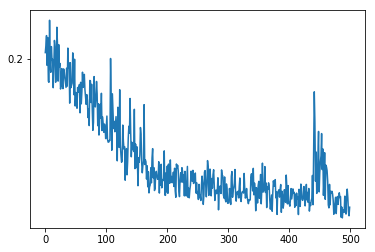

In [3]:
trainIters(50000)

Reading the parameters from check_point/encoder_simulation_3.ck and check_point/decoder_simulation_3.ck...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:299: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0m 16s (- 2m 29s) (5000 10%) 0.0083
0m 32s (- 2m 10s) (10000 20%) 0.0056
0m 49s (- 1m 55s) (15000 30%) 0.0041
1m 5s (- 1m 38s) (20000 40%) 0.0030
1m 21s (- 1m 21s) (25000 50%) 0.0028
1m 37s (- 1m 5s) (30000 60%) 0.0023
1m 54s (- 0m 48s) (35000 70%) 0.0021
2m 10s (- 0m 32s) (40000 80%) 0.0016
2m 26s (- 0m 16s) (45000 90%) 0.0016
2m 42s (- 0m 0s) (50000 100%) 0.0014


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<Figure size 432x288 with 0 Axes>

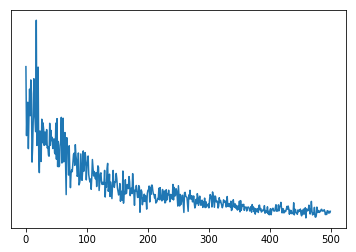

In [10]:
trainIters(50000)

In [100]:
lines = construct_dict(input_lang)
line = 'gros bisous'
line = normalizeString(line)
transform_line  = normalizeSentenceInChat(line)
transform_line = find_close_line(lines, input_lang, transform_line)
transform_line

'gros bisous'

In [11]:
evaluate_randomly(test=False)

Reading the parameters from check_point/encoder_simulation_3.ck and check_point/decoder_simulation_3.ck...
TEST error of word to word on TRAIN
Question:  quel véhicule batterie maximum
Réponse:  véhicule #id# #batterie# #MAX#
Bot: véhicule #id# #batterie# #MAX#   ACCURACY 1.0
--------------------------------------------------
Question:   danger batterie
Réponse:  véhicule #id# #danger# #batterie#
Bot: véhicule #id# #danger# #batterie#   ACCURACY 1.0
--------------------------------------------------
Question:  quelles voitures vitesse plus grand
Réponse:  véhicule #id# #vitesse# #MAX#
Bot: véhicule #id# #vitesse# #MAX#   ACCURACY 1.0
--------------------------------------------------
Question:  quel véhicule batterie minimales
Réponse:  véhicule #id# #batterie# #MIN#
Bot: véhicule #id# #batterie# #MIN#   ACCURACY 1.0
--------------------------------------------------
Question:  il y a erreur vitesse
Réponse:  véhicule #id# #erreur# #vitesse#
Bot: véhicule #id# #erreur# #vitesse#   ACCU

In [12]:
evaluate_randomly()

Reading the parameters from check_point/encoder_simulation_3.ck and check_point/decoder_simulation_3.ck...
Question:  quelle voiture batterie plus grande
Réponse:  véhicule #id# #batterie# #MAX#
Bot: véhicule #id# #batterie# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quelles voitures batterie plus grandes
Réponse:  véhicule #id# #batterie# #MAX#
Bot: véhicule #id# #batterie# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quels véhicules ont vitesse plus vite
Réponse:  véhicule #id# #vitesse# #MAX#
Bot: véhicule #id# #vitesse# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quel véhicule vitesse plus vite
Réponse:  véhicule #id# #vitesse# #MAX#
Bot: véhicule #id# #vitesse# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quels véhicules ont km plus vite
Réponse:  véhicule #id# #km# #MAX#
Bot: véhicule #id# #km# #MAX#. ACCURACY 1.0
-----------------

In [13]:
chat()

Reading the parameters from check_point/encoder_simulation_3.ck and check_point/decoder_simulation_3.ck...
Bonjour, c'est le Bot d'AVICEN, Je peux vous aider? 

Vous: danger
LIGNE TRANFORMÉ:  danger
Without Data:  véhicule #id# #danger# #batterie#
Bot AVICEN:  véhicule 520830.68253968254 #danger# #batterie#
--------------------------------------------------
Vous: vitesse max
LIGNE TRANFORMÉ:  vitesse max
Without Data:  véhicule #id# #vitesse# #MAX#
Bot AVICEN:  véhicule #id# 69.5004761904762 #MAX#
--------------------------------------------------
Vous: moins élevé
LIGNE TRANFORMÉ:  moins élevé
Without Data:  véhicule #id# #vitesse# #MAX#
Bot AVICEN:  véhicule #id# 69.5004761904762 #MAX#
--------------------------------------------------
Vous: vitesse moins élevé
LIGNE TRANFORMÉ:  vitesse moins élevé
Without Data:  véhicule #id# #vitesse# #MIN#
Bot AVICEN:  véhicule #id# 69.5004761904762 #MIN#
--------------------------------------------------
Vous: batterie le plus grande
LIGNE TRANFO

In [6]:
chat()

Reading the parameters from check_point/encoder_simulation_3.ck and check_point/decoder_simulation_3.ck...
Bonjour, c'est le Bot d'AVICEN, Je peux vous aider? 

Vous: véhicules en danger
LIGNE TRANFORMÉ:  véhicules en danger
Without Data:  véhicule #id# #km# #MIN#
Bot AVICEN:  véhicule #id# 1651.5582096507937 #MIN#
--------------------------------------------------
Vous: voitures roulent moins vite
LIGNE TRANFORMÉ:  voitures roulent moins vite
Without Data:  véhicule #id# #vitesse# #MAX#
Bot AVICEN:  véhicule #id# 69.5004761904762 #MAX#
--------------------------------------------------
Vous: voitures roulent le plus vites
LIGNE TRANFORMÉ:  voitures roulent le plus vites
Without Data:  véhicule #id# #km# #MIN#
Bot AVICEN:  véhicule #id# 1651.5582096507937 #MIN#
--------------------------------------------------
Vous: véhicule roulent moins vite
LIGNE TRANFORMÉ:  véhicule roulent moins vite
Without Data:  véhicule #id# #vitesse# #MAX#
Bot AVICEN:  véhicule #id# 69.5004761904762 #MAX#
--

In [93]:
key = []
for pair in pairs1:
    for word in pair[1].strip().split():
        if '#' in word and word not in key:
            key.append(word)
        

In [94]:
len(key)

33

In [8]:
evaluate_randomly()

Reading the parameters from check_point/encoder_simulation_3.ck and check_point/decoder_simulation_3.ck...
Question:  quelle voiture vitesse plus grande
Réponse:  véhicule #id# #vitesse# #MAX#
Bot: véhicule #id# #vitesse# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quelles voitures batterie plus grands
Réponse:  véhicule #id# #batterie# #MAX#
Bot: véhicule #id# #batterie# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quelles voitures batterie plus grandes
Réponse:  véhicule #id# #batterie# #MAX#
Bot: véhicule #id# #batterie# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quels véhicules ont vitesse maximum
Réponse:  véhicule #id# #vitesse# #MAX#
Bot: véhicule #id# #vitesse# #MAX#. ACCURACY 1.0
--------------------------------------------------
Question:  quels véhicules ont batterie maximaux
Réponse:  véhicule #id# #batterie# #MAX#
Bot: véhicule #id# #batterie# #MAX#. ACCURACY 1